In [20]:
!pip install neo4j
!pip install graphdatascience
%matplotlib inline

import json
import time
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from neo4j import GraphDatabase
from graphdatascience import GraphDataScience as gds
#from neo4j import GraphDataScience as gds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# A wrapper class to manage connection
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [ ]:
# Actually create a connection. Copy uri (with bolt port), username and passwords from your own sandbox instance
conn = Neo4jConnection(uri="bolt://18.204.247.82:7687", user="neo4j", pwd="airplane-milestones-diary")

# Q1 read node (character)  files for all eight seasons and merge them to the same database.

# Q2. read edge (character interaction)  files for all eight seasons and merge them to the same database. However, character interactions in different seasons should have different types. 

In [ ]:
# clear data
# DETACH will remove add edges as well
query_string = '''
MATCH (c:Character) 
DETACH DELETE c;
'''
conn.query(query_string)

# # read characters from season1 to season 8 of GOT and add as Character nodes 
# # MERGE: This operation creates a node with label "Character" and a property "id" with the value of "row.Id" from the CSV file. 
# # If a node with the same "id" already exists in the graph database, it updates the properties of that node.
# # SET: This operation sets the value of the "name" property of the created/updated node to the value of "row.Label" from the CSV file.

# Q 1 & Q 2

seasons = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8']

# loop through the seasons and add nodes and edges
for season in seasons:

    # Q1
    
    # read characters from the season and add as Character nodes 
    query_string = f'''
    WITH "https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/got-{season}-nodes.csv" AS uri
    LOAD CSV WITH HEADERS FROM uri AS row 
    MERGE (c:Character {{id:row.Id}})
    SET c.name = row.Label
    '''
    conn.query(query_string)

    # Q2

    # read character interactions from the season and add as edges
    query_string = f'''
    WITH "https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/got-{season}-edges.csv" AS uri
    LOAD CSV WITH HEADERS FROM uri AS row
    MATCH (source:Character {{id: row.Source}})
    MATCH (target:Character {{id: row.Target}})
    MERGE (source)-[:SEASON{season[1].upper()} {{weight: toInteger(row.Weight)}}]-(target)
    '''
    conn.query(query_string)






# Q3. Compute degrees of nodes separately for each season. That means, compute degrees separately for each of eight subgraphs (each subgraph denotes character interactions in each season). The notebook already has an example for season 1. Also compute the degrees of nodes for the entire graph created from all seasons.

In [ ]:
# Degrees of nodes - separately for each of the 8 seasons

query_string = '''
MATCH (c:Character) 
RETURN c.name, 
       SIZE([(c)-[:SEASON1]->() | 1]) AS season1InDegree,
       SIZE([(c)-[:SEASON2]->() | 1]) AS season2InDegree,
       SIZE([(c)-[:SEASON3]->() | 1]) AS season3InDegree,
       SIZE([(c)-[:SEASON4]->() | 1]) AS season4InDegree,
       SIZE([(c)-[:SEASON5]->() | 1]) AS season5InDegree,
       SIZE([(c)-[:SEASON6]->() | 1]) AS season6InDegree,
       SIZE([(c)-[:SEASON7]->() | 1]) AS season7InDegree,
       SIZE([(c)-[:SEASON8]->() | 1]) AS season8InDegree 
ORDER BY season1InDegree DESC, 
         season2InDegree DESC,
         season3InDegree DESC,
         season4InDegree DESC,
         season5InDegree DESC,
         season6InDegree DESC,
         season7InDegree DESC,
         season8InDegree DESC
'''
top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
print(top_cat_df.head(30))

       c.name  season1InDegree  season2InDegree  season3InDegree  \
0     Catelyn               29               19               16   
1        Arya               28               25               15   
2      Cersei               23               28               18   
3         Ned               23               10                7   
4     Joffrey               18               23               14   
5        Bran               18               13               17   
6    Daenerys               17               13               10   
7       Jaime               16               12               13   
8       Petyr               15               13                9   
9         Jon               14                6               12   
10     Sandor               13               10                7   
11      Bronn               12               15               14   
12      Aerys               12                4                5   
13       Jeor               10                4 

In [ ]:


# See the degrees of nodes for all seasons together
query_string = '''
MATCH (c:Character) 
RETURN c.name, SIZE([(c)-[]->(s) | s]) AS inDegree 
ORDER BY inDegree DESC 
'''
top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
print(top_cat_df.head(30))


       c.name  inDegree
0      Cersei       192
1        Arya       176
2    Daenerys       141
3         Jon       135
4        Bran       125
5       Jaime       115
6       Davos       111
7     Brienne       105
8     Joffrey       102
9       Bronn        98
10    Catelyn        87
11      Petyr        82
12     Sandor        77
13        Ned        67
14    Eddison        55
15      Jorah        54
16  Grey Worm        52
17     Gendry        49
18      Beric        47
19      Gilly        47
20      Sansa        46
21    Ellaria        44
22      Loras        43
23    Alliser        42
24      Aerys        38
25       Robb        36
26  Barristan        33
27    Podrick        33
28      Hodor        31
29     Edmure        30


# Q4. From season 1  find 10 nodes with the highest degrees. Then, for these 10 nodes, plot their degrees found in every season subgraph as well as for on the  overall graph. That means, for each of the selected 10 nodes, you will have 9 numbers (one for each season and the last one for the overall graph). Please line plots where one line denotes one of the ten characters. x axis of the plot denotes seasons, and y axis denotes degree.

In [ ]:
import matplotlib.pyplot as plt

# Query to get the top 10 nodes with highest degrees in Season 1
query_string = '''
MATCH (c:Character)
RETURN c.name, SIZE([(c)-[:SEASON1]->(s) | s]) AS inDegree 
ORDER BY inDegree DESC LIMIT 10
'''''

# Get the top 10 nodes with highest degrees in Season 1
top_10_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])


# List of the top 10 nodes
top_10_nodes = top_10_df['c.name'].tolist()

print(top_10_nodes)



['Catelyn', 'Arya', 'Ned', 'Cersei', 'Joffrey', 'Bran', 'Daenerys', 'Jaime', 'Petyr', 'Jon']


In [66]:

final_df = pd.DataFrame()

for character_name in top_10_nodes:


    # Iterate over all seasons (1 to 8)
    for season in range(1, 9):
  
      query_string = f'''
      MATCH (c:Character)
      WHERE c.name = '{character_name}' 
      RETURN c.name, 
      SIZE([(c)-[:SEASON{season}]->() | 1]) AS degree
      
      '''

      query_params = {'character_name': character_name, 'season': season}
      season_df = pd.DataFrame([dict(_) for _ in conn.query(query_string, query_params)])
      season_df['season'] = str(season)
      final_df = pd.concat([final_df, season_df])
    
    query_string = f'''
      MATCH (c:Character)
      WHERE c.name = '{character_name}' 
      RETURN c.name, 
      SIZE([(c)-[]->() | 1]) AS degree
      
      ''' 
    query_params = {'character_name': character_name}
    season_df = pd.DataFrame([dict(_) for _ in conn.query(query_string, query_params)])
    season_df['season'] = 'all season'
    final_df = pd.concat([final_df, season_df])

final_df = final_df.reset_index(drop=True)

final_df

,c.name,degree,season
0,Catelyn,29,1
1,Catelyn,19,2
2,Catelyn,16,3
3,Catelyn,11,4
4,Catelyn,4,5
...,...,...,...
85,Jon,18,5
86,Jon,21,6
87,Jon,24,7
88,Jon,20,8


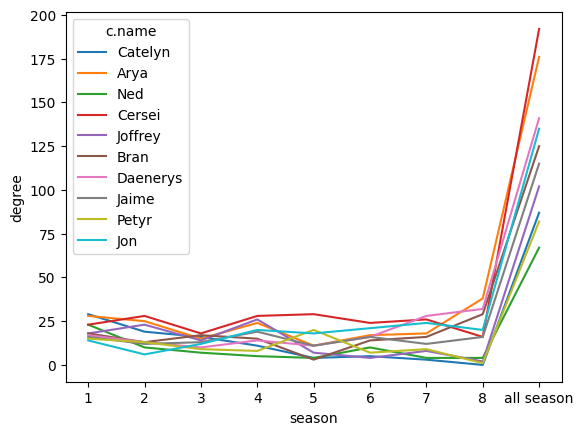

In [65]:
sns.lineplot(data = final_df, x = 'season', y = 'degree', hue = 'c.name', markers = True)
plt.show()

# Q5. Write a Cypher query to  find the pair of characters that had the most interactions in each season and their corresponding weights. Interactions are represented as edges in the graph. The greater the weight of the edge, the  greater the interaction between the nodes(characters) joining that edge.

In [45]:

final_df_for_interactions = pd.DataFrame()

for season in range(1,9):
  query_string = f'''
  MATCH (c1:Character)-[r:SEASON{season}]-(c2:Character)
  RETURN c1.name, c2.name, r.weight
  ORDER BY r.weight DESC
  LIMIT 1
  '''
  query_params = {'season': season}
  season_df = pd.DataFrame([dict(_) for _ in conn.query(query_string, query_params)])
  season_df['season'] = str(season)
  final_df_for_interactions = pd.concat([final_df_for_interactions, season_df])

# The following dataframe outputs the pairs of character that. had the most interaction in each season wih their corresponding weights and season
final_df_for_interactions

,c1.name,c2.name,r.weight,season
0,Ned,Robert,192,1
0,Cersei,Tyrion,177,2
0,Jon,Ygritte,159,3
0,Arya,Sandor,162,4
0,Arya,Jaqen,148,5
0,Jon,Sansa,151,6
0,Daenerys,Tyrion,179,7
0,Daenerys,Jon,194,8


# Q6. For the combined graph of all seasons, write a Cypher query to find the top 10 characters(nodes) that have interactions with the most number of distinct characters.

In [56]:
query_string = '''
MATCH (c1:Character)-[]-(c2:Character)
WITH c1, count(distinct c2) as num_distinct_characters
ORDER BY num_distinct_characters DESC
LIMIT 10
RETURN c1.name ,num_distinct_characters
'''

df = pd.DataFrame([dict(_) for _ in conn.query(query_string, query_params)])
df

,c1.name,num_distinct_characters
0,Tyrion,128
1,Jon,105
2,Sansa,101
3,Arya,97
4,Daenerys,93
5,Jaime,90
6,Cersei,86
7,Sam,78
8,Ned,78
9,Davos,78


In [ ]:

# #Create a projecttion of the season 1 subgraph
# query_string = '''
# CALL gds.graph.project.cypher(
#     'season1_graph',
#     'MATCH (n) RETURN id(n) AS id',
#     'MATCH (n)-[e:SEASON1]-(m) RETURN id(n) AS source, e.weight AS weight, id(m) AS target'
# )
# '''
# conn.query(query_string)

In [ ]:
# # Compute pagerank of the season 1 subgraph
# query_string = '''
# CALL gds.pageRank.stream('season1_graph', {
#   maxIterations: 100,
#   dampingFactor: 0.85,
#   relationshipWeightProperty: 'weight'
# })
# YIELD nodeId, score
# RETURN gds.util.asNode(nodeId).id AS id,      gds.util.asNode(nodeId).name as name, score as full_pagerank
# ORDER BY full_pagerank DESC
# '''
# conn.query(query_string)

In [ ]:
# # Detect communities from the season 1 subgraph
# query_string = '''
# CALL gds.louvain.write('season1_graph', 
#     {relationshipWeightProperty: 'weight', 
#      writeProperty: 'full_community_id'
# })
# '''
# conn.query(query_string)